In [1]:
import jax.numpy as jnp
import bayes3d as b
import os
import jax
import functools
from jax.scipy.special import logsumexp, erf
from functools import partial
from tqdm import tqdm
import matplotlib.pyplot as plt
import gc

In [2]:
b.setup_visualizer()

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7001/static/


In [3]:
def single_patch_likelihood(p: jnp.ndarray,
                            bottom_left: jnp.ndarray,
                            top_right: jnp.ndarray,
                            sigma: float):
    x, y, z = bottom_left
    X, Y, _ = top_right
    C = (2*jnp.pi)**(-3/2)  * sigma**(-3)
    z_term = jnp.exp(- (p[2] - z)**2/sigma**2)
    x_term = jnp.sqrt(jnp.pi) * sigma / 2 * (erf((p[0] - 2*x) / sigma) + erf((- p[0] + x + X) / sigma))
    y_term = jnp.sqrt(jnp.pi) * sigma / 2 * (erf((p[1] - 2*y) / sigma) + erf((- p[1] + y + Y) / sigma))
    return C * x_term * y_term * z_term

In [4]:
intrinsics = b.Intrinsics(
    height=100,
    width=100,
    fx=200.0, fy=200.0,
    cx=50.0, cy=50.0,
    near=0.0001, far=2.0
)

b.setup_renderer(intrinsics)
model_dir = os.path.join(b.utils.get_assets_dir(),"bop/ycbv/models")
b.RENDERER.add_mesh_from_file(model_dir + '/obj_000014.ply', scaling_factor=1e-3)
b.RENDERER.add_mesh_from_file(os.path.join(b.utils.get_assets_dir(), "sample_objs/cube.obj"), scaling_factor=1.0/1000000000.0)

[E rasterize_gl.cpp:121] OpenGL version reported as 4.6


Increasing frame buffer size to (width, height, depth) = (128, 128, 1024)


In [5]:
table_pose = b.t3d.inverse_pose(
    b.t3d.transform_from_pos_target_up(
        jnp.array([0.0, 0.8, .15]),
        jnp.array([0.0, 0.0, 0.0]),
        jnp.array([0.0, 0.0, 1.0]),
    )
)

In [6]:
def get_poses_non_jit(contact_params, id_table, id):
    sg = b.scene_graph.SceneGraph(
        root_poses=jnp.array([table_pose, jnp.eye(4)]),
        box_dimensions=jnp.array([b.RENDERER.model_box_dims[id_table], b.RENDERER.model_box_dims[id]]),
        parents=jnp.array([-1, 0]),
        contact_params=jnp.array([jnp.zeros(3), contact_params]),
        face_parent=jnp.array([-1,2]),
        face_child=jnp.array([-1,3]),
    )
    poses = sg.get_poses()
    return poses
get_poses = jax.jit(get_poses_non_jit)

def render_image_non_jit(dx, dy, theta):
    id_table = 1
    id = 0
    poses = get_poses_non_jit(jnp.array([dx, dy, theta]), id_table, id)
    img = b.RENDERER.render(
        poses , jnp.array([id_table, id])
    )[...,:3]
    return img
    
render_image = jax.jit(render_image_non_jit)

In [7]:
jnp.array([b.RENDERER.model_box_dims[1], b.RENDERER.model_box_dims[0]])

Array([[1.00000e-09, 1.00000e-09, 1.00000e-09],
       [1.16966e-01, 9.30750e-02, 8.13840e-02]], dtype=float32)

In [8]:
DX_MEAN, DX_STD = 0.0, 0.1
DY_MEAN, DY_STD = 0.0, 0.1
THETA_MEAN, THETA_STD = 0.0, jnp.pi
def sample_image_non_jit(key):
    dx_key, dy_key, theta_key = jax.random.split(key, 3)
    dx = DX_MEAN #+ DX_STD * jax.random.normal(dx_key)
    dy = DY_MEAN #+ DY_STD * jax.random.normal(dy_key)
    theta = jax.random.uniform(theta_key) * 2 * jnp.pi
    #THETA_MEAN + THETA_STD * jax.random.normal(theta_key)
    return render_image_non_jit(dx, dy, theta), theta

In [9]:
sample_image = jax.jit(sample_image_non_jit)

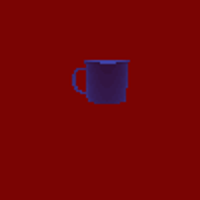

In [10]:
b.viz.scale_image(b.get_depth_image(render_image(0.0, 0.0, jnp.pi/2)[:, :, 2]), 2)

In [11]:
key = jax.random.PRNGKey(0)

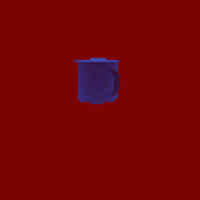

In [12]:
key = jax.random.split(key, 2)[0]
b.viz.scale_image(b.get_depth_image(sample_image(key)[0][:, :, 2]), 2)

In [13]:
@jax.jit
def make_batch(batch_keys):
    batch_size = batch_keys.shape[0]
    def loop_body(i, imgs_labels):
        imgs, labels = imgs_labels
        img, label = sample_image(batch_keys[i])
        return (imgs.at[i, :, :, 0].set(img[:, :, 2]),
                labels.at[i, :].set(label))
    return jax.lax.fori_loop(0, batch_keys.shape[0],
                             loop_body,
                             (jnp.zeros((batch_size, 100, 100,1)), jnp.zeros((batch_size, 1))))

In [14]:
N_TRAIN = 60000 
N_TEST = 2000

In [15]:
train_data_noxy = make_batch(jax.random.split(jax.random.PRNGKey(0), N_TRAIN))
jnp.savez('train_data_noxy.npz', *train_data_noxy)

In [22]:
test_data_noxy = make_batch(jax.random.split(jax.random.PRNGKey(2718), N_TEST))

In [23]:
jnp.savez('test_data_noxy.npz', *test_data_noxy)